# Библиотеки 

In [1]:
from classes_and_definitions import *
import pickle
import time 
from tqdm import tqdm
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency

warnings.filterwarnings("ignore")

# Загрузка данных и пример использования

## Инициализируем объект класса для прогнозирования

In [2]:
with open('./Вспомогательные файлы/category_models.pkl', 'rb') as f:
    topic_modeling_dict = pickle.load(f)
    
with open('./Вспомогательные файлы/sentiment_classifier.pkl', 'rb') as f:
    sentiment_classifier = pickle.load(f)
    
with open('./Вспомогательные файлы/product_classifer.pkl', 'rb') as f:
    product_classifier = pickle.load(f)

with open('./Вспомогательные файлы/allowed_lemmas.pkl', 'rb') as f:
    allowed_lemmas = pickle.load(f)
    tokenizer=NLTKWordTokenizer()
    text_transformer = TextTransformer(allowed_lemmas)
    
mapping = dict()

mapping['autocredits'] = {0: {0: 'Неудовлетворительные условия кредитования',
                             1: 'Проблемы с процессом обращения и обработки заявки',
                             2: 'Проблемы с платежами и погашением кредита',
                             3: 'Проблемы с залогом и автомобилем',
                             4: 'Неудовлетворенность условиями автокредита'},
                         1: {0: 'Хорошее обслуживание',
                             1: 'Удовлетворенность процессом оформления автокредита',
                             2: 'Удовлетворенность условиями кредита и выплатами по кредиту',
                             3: 'Удовлетворенность процессом закрытия автокредита',
                             4: 'Положительный опыт использования рассрочки'}
                         }

mapping['credits'] = {0: {0: 'Проблемы с условиями кредита и страхованием',
                             1: 'Проблемы с обслуживанием и обработкой заявок',
                             2: 'Проблемы с платежами и счетами',
                             3: 'Проблемы с кредитной историей и исполнительным производством',
                             4: 'Проблемы с обращением в банк и услугами поддержки'},
                         1: {0: 'Положительный опыт общения с сотрудниками банка',
                             1: 'Быстрое оформление кредита',
                             2: 'Положительный опыт использования мобильного приложения',
                             3: 'Поддержка для развития бизнеса',
                             4: 'Удобство и гибкость условий использования кредитной карты'}
                         }

mapping['deposits'] = {0: {0: 'Проблемы с исполнительным производством и взысканием долгов',
                             1: 'Проблемы с доступом к счету',
                             2: 'Проблемы с обработкой заявок по горячей линии',
                             3: 'Проблемы с комиссиями и снятием средств с депозитов',
                             4: 'Неудовлетворительные условия депозитов'},
                         1: {0: 'Удовлетворенность гибкими условиями депозитов',
                             1: 'Положительный опыт обслуживания в отделении',
                             2: 'Удовлетворение услугами депозитов, предоставляемыми с использованием карточки',
                             3: 'Удовлетворение качеством мобильного приложения банка',
                             4: 'Удовлетворение процентными ставками и удобством общения с операторами'}
                         }

mapping['hypothec'] = {0: {0: 'Проблемы с условиями ипотечного кредитования',
                             1: 'Отказы по ипотеке и проблемы с коммуникацией с менеджерами',
                             2: 'Проблемы с платежами и денежными операциями по ипотеке',
                             3: 'Сложность процедуры получения ипотеки',
                             4: 'Проблемы со страховкой при оформлении ипотеки'},
                         1: {0: 'Удовлетворенность процессом осуществлени сделки',
                             1: 'Положительный опыт обслуживания в отделении',
                             2: 'Хорошая работа менеджера и отсутствие проблем при подписании договора',
                             3: 'Положительный опыт обслуживания ипотеки',
                             4: 'Выгодные условия, низкая ставка по ипотеке'}
                         }

mapping['creditcards'] = {0: {0: 'Проблемы с списыванием средств и дополнительными комиссиями',
                             1: 'Недовольство условиями акций по карте',
                             2: 'Неудовлетворенность результатом обращения в банк',
                             3: 'Проблемы с исполнением обязательств',
                             4: 'Проблемы с погашением задолженности'},
                         1: {0: 'Эффективное обслуживание и поддержка клиентов',
                             1: 'Удобное приложение',
                             2: 'Удобное оформление карты',
                             3: 'Выгодные условия использования кредитной карты',
                             4: 'Преимущества программ лояльности и рассрочки'}
                         }

mapping['debitcards'] = {0: {0: 'Проблемы с оформлением и предоставлением документов',
                             1: 'Проблемы с доступом к счету',
                             2: 'Проблемы с использованием дебетовой карты',
                             3: 'Неудовлеворенность пенсионеров использованием дебетовой карты',
                             4: 'Неясность условий акций и начисления бонусов'},
                         1: {0: 'Разнообразные финансовые возможности',
                             1: 'Удобство использования мобильного приложения',
                             2: 'Удобство использования дебетовых карт',
                             3: 'Качественное оформление дебетовой карты',
                             4: 'Оперативность работы поддержки'}
                         }

response_decomposition = ResponseDecomposition(
    sentiment_classifier=sentiment_classifier,
    category_classifier=product_classifier,
    topic_modeling=topic_modeling_dict,
    text_transformer=text_transformer
)

## Пример с обработкой текста и ряда из текстов

In [3]:
test_text = "Дебетовые карты? Что? нет, не слышал. Ваша компания - обманщики и лузеры. Я за киберкоммунизм"

result_text = response_decomposition.transform(
    test_text,
    need_topic=True,
    need_sentiment=True,
    need_category=True,
    task_type_sentiment='tfidf',
    classifier_name_sentiment='svm',
    task_type_category='tfidf',
    classifier_name_category='logreg',
    sentiment_for_category_classifier=True,
    threshold_for_sentiment=0.58,
    topic_mapping=mapping
)

result_text

,sentiment,category,topic
0,0,debitcards,Проблемы с использованием дебетовой карты


In [4]:
test_series = pd.Series(['Я сказал', 'король молчит', ', а ты кушаешь вопперы'])

result_series = response_decomposition.transform(
    test_series,
    need_topic=True,
    need_sentiment=True,
    need_category=True,
    task_type_sentiment='tfidf',
    classifier_name_sentiment='svm',
    task_type_category='tfidf',
    classifier_name_category='logreg',
    sentiment_for_category_classifier=True,
    threshold_for_sentiment=0.58,
    topic_mapping=mapping
)
result_series

,sentiment,category,topic
0,0,credits,Проблемы с обслуживанием и обработкой заявок
1,1,debitcards,Разнообразные финансовые возможности
2,1,debitcards,Разнообразные финансовые возможности


In [5]:
test_text = "Я за устойчивую экономику без долгов"

result_text = response_decomposition.transform(
    test_text,
    need_topic=True,
    need_sentiment=True,
    need_category=True,
    task_type_sentiment='tfidf',
    classifier_name_sentiment='svm',
    task_type_category='tfidf',
    classifier_name_category='logreg',
    sentiment_for_category_classifier=True,
    threshold_for_sentiment=0.58,
    topic_mapping=mapping
)

result_text

,sentiment,category,topic
0,0,credits,Проблемы с кредитной историей и исполнительным...


In [6]:
test_text = "Никогда больше не буду пользоваться услугами этого банка. Меня обманули и списали проценты"

result_text = response_decomposition.transform(
    test_text,
    need_topic=True,
    need_sentiment=True,
    need_category=True,
    task_type_sentiment='tfidf',
    classifier_name_sentiment='svm',
    task_type_category='tfidf',
    classifier_name_category='logreg',
    sentiment_for_category_classifier=True,
    threshold_for_sentiment=0.58,
    topic_mapping=mapping
)

result_text

,sentiment,category,topic
0,0,credits,Проблемы с платежами и счетами


# Аналитика
### Данный раздел иллюстрирует пример того, как можно использовать построенные модели

## Загрузка датафрейма и выделение тем

In [7]:
data = pd.read_csv('./Вспомогательные файлы/dataset_for_modeling.csv')
data['lemmas'] = data['lemmas'].str.replace(r'[\[\],\']', '').str.split()
data = data[data['grade'] != 'unknown']
data['grade'] = data['grade'].replace({'good' : 1, 'bad' : 0}).astype(int)
data.head(3)

,text,city,date,rating,grade,bank,category,site,week,month,lemmas_with_tags,lemmas
0,21.01.2024 сделала заявку на перенос даты плат...,Москва,2024-01-23,1,0,МТС Банк,credits,banki_ru,2024-01-22/2024-01-28,2024-01,"['сделать_VERB', 'заявка_NOUN', 'перенос_NOUN'...","[сделать, заявка, перенос, дата, платеж, прило..."
1,Сталкнулся с такой проблемой что при переводе ...,Екатеринбург,2024-01-23,1,0,МТС Банк,credits,banki_ru,2024-01-22/2024-01-28,2024-01,"['проблема_NOUN', 'перевод_NOUN', 'деньги_NOUN...","[проблема, перевод, деньги, заблокировать, опе..."
2,15-16/01 пытался перевести деньги с дебетовой ...,Санкт-Петербург,2024-01-18,2,0,МТС Банк,credits,banki_ru,2024-01-15/2024-01-21,2024-01,"['пытаться_VERB', 'перевести_VERB', 'деньги_NO...","[пытаться, перевести, деньги, дебетовый, карта..."


In [8]:
response_decomposition = ResponseDecomposition(
    sentiment_classifier=sentiment_classifier,
    category_classifier=product_classifier,
    topic_modeling=topic_modeling_dict,
    text_transformer=text_transformer
)
data['topics'] = response_decomposition._predict_topic(
    data['lemmas'], mapping, data['category'].values, data['grade'].values)

In [9]:
data.head(2)

,text,city,date,rating,grade,bank,category,site,week,month,lemmas_with_tags,lemmas,topics
0,21.01.2024 сделала заявку на перенос даты плат...,Москва,2024-01-23,1,0,МТС Банк,credits,banki_ru,2024-01-22/2024-01-28,2024-01,"['сделать_VERB', 'заявка_NOUN', 'перенос_NOUN'...","[сделать, заявка, перенос, дата, платеж, прило...",Проблемы с платежами и счетами
1,Сталкнулся с такой проблемой что при переводе ...,Екатеринбург,2024-01-23,1,0,МТС Банк,credits,banki_ru,2024-01-22/2024-01-28,2024-01,"['проблема_NOUN', 'перевод_NOUN', 'деньги_NOUN...","[проблема, перевод, деньги, заблокировать, опе...",Проблемы с платежами и счетами


## OverView

In [10]:
grouped_data = data.groupby('bank').size()
selected_banks = grouped_data[grouped_data > 100].index.tolist()
filtered_bank_data = data[data['bank'].isin(selected_banks)] # Оставим только банки с 100+ отзывами
filtered_bank_data['site'] = filtered_bank_data['site'].replace({'banki_ru' : 1, 'sravni_ru' : 0})
filtered_bank_data = filtered_bank_data.groupby('bank').agg({'rating' : 'mean', 'date' : 'size', 'site' : 'mean'}).sort_values(by = 'rating', ascending = False)
filtered_bank_data.rename(columns = {'rating' : 'Mean grade', 'date' : 'Number of responses', 'site' : 'Share of banki.ru'}, inplace = True)
filtered_bank_data


,Mean grade,Number of responses,Share of banki.ru
bank,,,
Банк Точка,5.000000,182,0.000000
Банк «Центр-инвест»,4.945205,219,0.095890
Московский кредитный банк (МКБ),4.857143,490,1.000000
Русский Стандарт,4.795154,454,0.991189
Совкомбанк,4.747432,4284,0.576797
Абсолют Банк,4.741667,120,0.791667
Кредит Европа Банк,4.741007,278,0.985612
Экспобанк,4.659218,179,0.486034
Россельхозбанк,4.492978,712,0.803371


In [11]:
np.corrcoef(filtered_bank_data['Mean grade'], filtered_bank_data['Share of banki.ru'])


array([[ 1.        , -0.46100596],
       [-0.46100596,  1.        ]])

In [12]:
grouped_data = data.groupby('bank').size()
selected_banks = grouped_data[grouped_data >= 100].index.tolist()
filtered_df = data[data['bank'].isin(selected_banks)]

merged_data = filtered_df.groupby(['bank', 'site']).agg({'grade': lambda x: (x == 0).mean()}).reset_index()
merged_data.rename(columns={'grade': 'relative_negative_reviews'}, inplace=True)

Можно выдвинуть гипотезу о том, что на сравни.ру оставляется меньше плохих отзывов

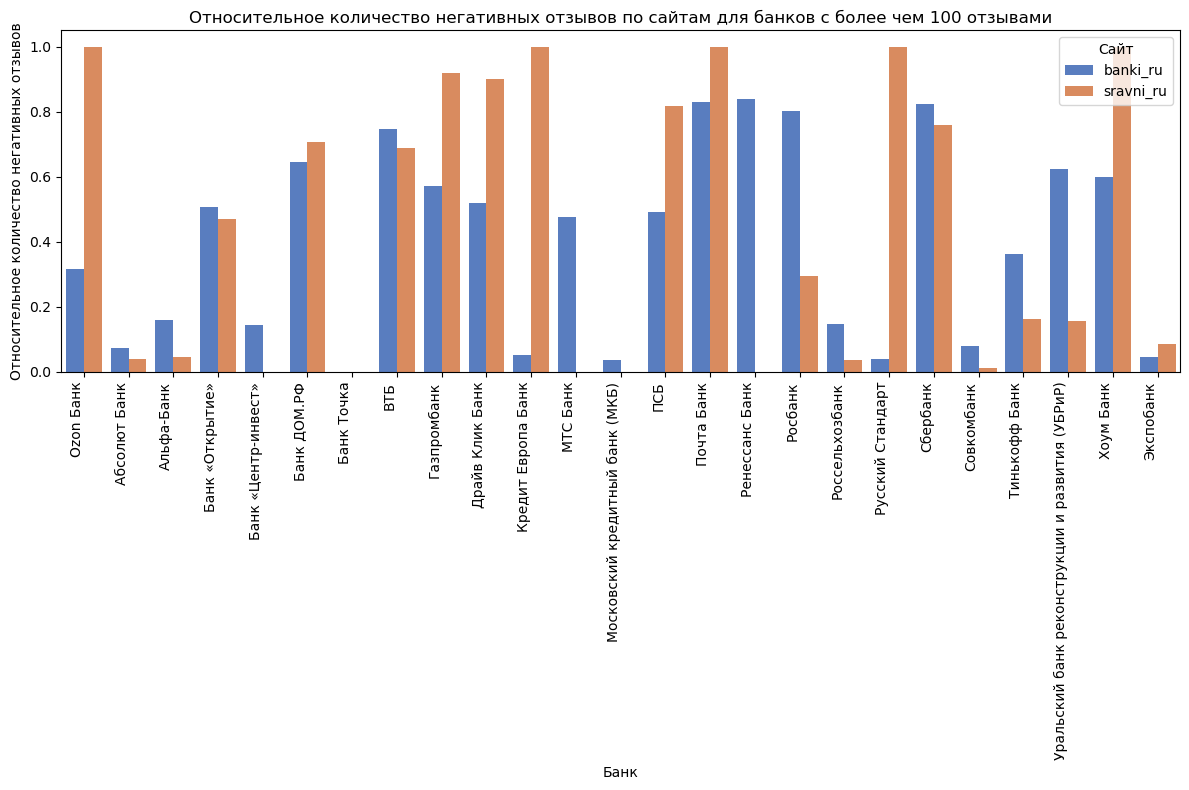

In [13]:
plt.figure(figsize=(12, 8))

sns.barplot(x='bank', y='relative_negative_reviews', hue='site', data=merged_data, palette='muted')

plt.title('Относительное количество негативных отзывов по сайтам для банков с более чем 100 отзывами')
plt.xlabel('Банк')
plt.ylabel('Относительное количество негативных отзывов')
plt.xticks(rotation=90, ha='right') 

plt.legend(title='Сайт')

plt.tight_layout()
plt.show()

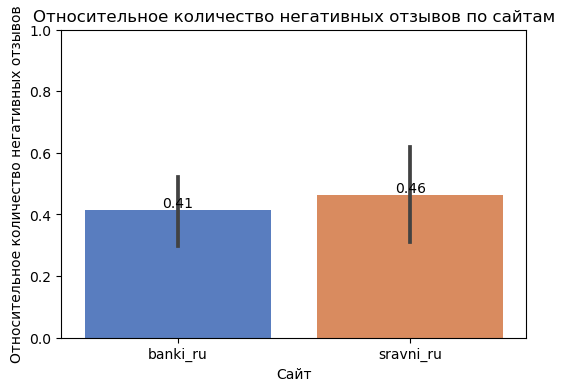

In [14]:
plt.figure(figsize=(6, 4))

sns.barplot(x='site', y='relative_negative_reviews', data=merged_data, palette='muted')

plt.title('Относительное количество негативных отзывов по сайтам')
plt.xlabel('Сайт')
plt.ylabel('Относительное количество негативных отзывов')
plt.ylim(0, 1)

for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                       textcoords='offset points')

plt.show()

In [15]:
# воспользуемся χ2-критерием для проверки гипотезы о равенстве двух долей

contingency_table = pd.crosstab(data['grade'], data['site'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Хи-квадрат статистика: {chi2}")
print(f"p-value: {p}")

alpha = 0.05
if p <= alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимая разница между долями отрицательных отзывов на двух сайтах.")
else:
    print("Нет оснований отвергать нулевую гипотезу: нет статистически значимой разницы между долями отрицательных отзывов на двух сайтах.")


Хи-квадрат статистика: 879.4239031651427
p-value: 2.916582634724186e-193
Отвергаем нулевую гипотезу: существует статистически значимая разница между долями отрицательных отзывов на двух сайтах.


Можем говорить о том, что на сравни.ру в целом публикуется больше отрицательных отзывов чем на banki.ru

## Слабые и сильные стороны

### В целом в банковском секторе

In [16]:
data_top_banks = data.copy()
size_of_segment = data_top_banks.groupby(['category', 'grade'])['topics'].size().to_frame()
size_of_segment = size_of_segment.reset_index(level = [0, 1]).rename(columns = {'topics' : 'size of segment'})
grouped_data = data_top_banks.groupby(['category', 'grade'])['topics'].apply(lambda x: x.mode().iloc[0]).reset_index()
topic_counts = data_top_banks.groupby(['category', 'grade'])['topics'].apply(lambda x: x.value_counts(normalize=True)).to_frame()
topic_counts = topic_counts.reset_index(level = [0, 1, 2]).rename(columns = {'level_2' : 'topics', 'topics' : 'share of topic among segment'})
topic_counts['share of topic among segment'] = topic_counts['share of topic among segment'].apply(lambda x: round(x, 2))
grouped_data = grouped_data.merge(topic_counts, on=['category', 'grade', 'topics'], how='left')
grouped_data = grouped_data.merge(size_of_segment, on=['category', 'grade'], how='left')
helpful_frame = grouped_data.groupby(['category'])['size of segment'].sum().rename('size')
grouped_data = grouped_data.merge(helpful_frame, on=['category'], how='left')
grouped_data['share of such sentiment among category'] = (grouped_data['size of segment'] / grouped_data['size']).apply(lambda x: round(x, 2))
grouped_data.drop(columns = ['size'], inplace = True)
grouped_data

,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
0,autocredits,0,Проблемы с процессом обращения и обработки заявки,0.51,650,0.33
1,autocredits,1,Удовлетворенность процессом оформления автокре...,0.61,1332,0.67
2,creditcards,0,Неудовлетворенность результатом обращения в банк,0.79,521,0.18
3,creditcards,1,Удобное приложение,0.36,2370,0.82
4,credits,0,Проблемы с обслуживанием и обработкой заявок,0.41,584,0.20
5,credits,1,Быстрое оформление кредита,0.50,2375,0.80
6,debitcards,0,Проблемы с использованием дебетовой карты,0.84,684,0.25
7,debitcards,1,Оперативность работы поддержки,0.33,2043,0.75
8,deposits,0,Проблемы с доступом к счету,0.73,508,0.18
9,deposits,1,Положительный опыт обслуживания в отделении,0.45,2363,0.82


**Общие тенденции:**

- Проблемы, связанные с обслуживанием заявок, преобладают в большинстве категорий: autocredits (51%), creditcards (79%), credits (41%)

- Положительный опыт чаще всего связан со скоростью и удобством процессов: creditcards (36%), credits (50%), debitcards (33%)

- Положительных отзывов по всем категориям больше, чем негативных. В среднем их 20%. На этом фоне выбивается тема с ипотеками у которой почти половина отзывов негативные и тема автокредитования - там 33% отзывов негативные.

**Особенности категорий:**

- Главная проблема категории "ипотека" (hypothec) характерна только для данной категории и связана с частыми отказами и проблемами с коммуникацией с банками.
- Удобность приложения чаще всего высоко оценивается в сфере взаимодействия с кредитными картами, а работа поддержки - в взаимодействи с дебетовыми картами
- Обслуживание - самый противоречивый процесс, его хвалят в таких категориях, как ипотеки и депозиты, а ругают в автокредитах, кредитных картах, кредитах

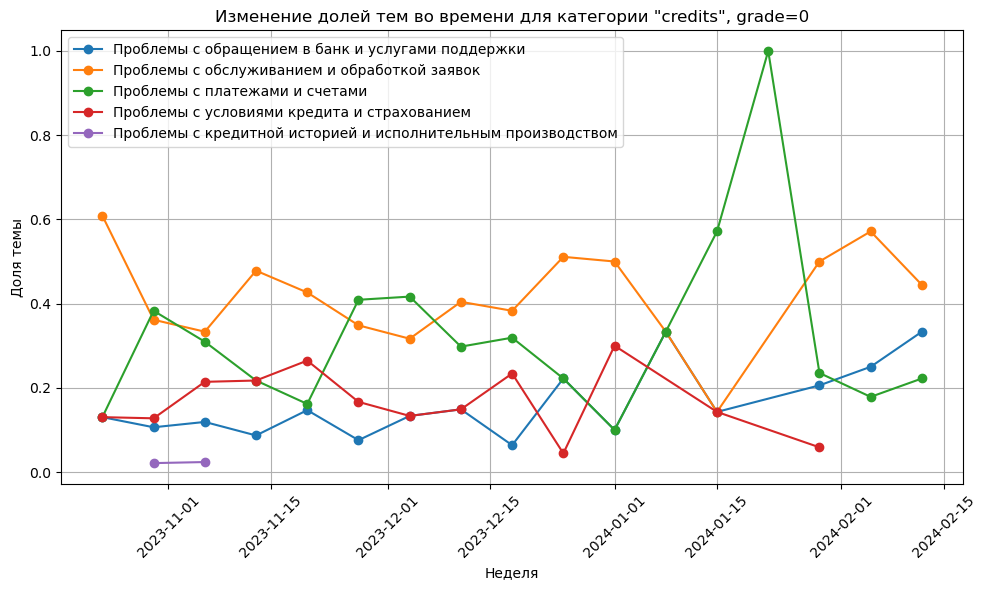

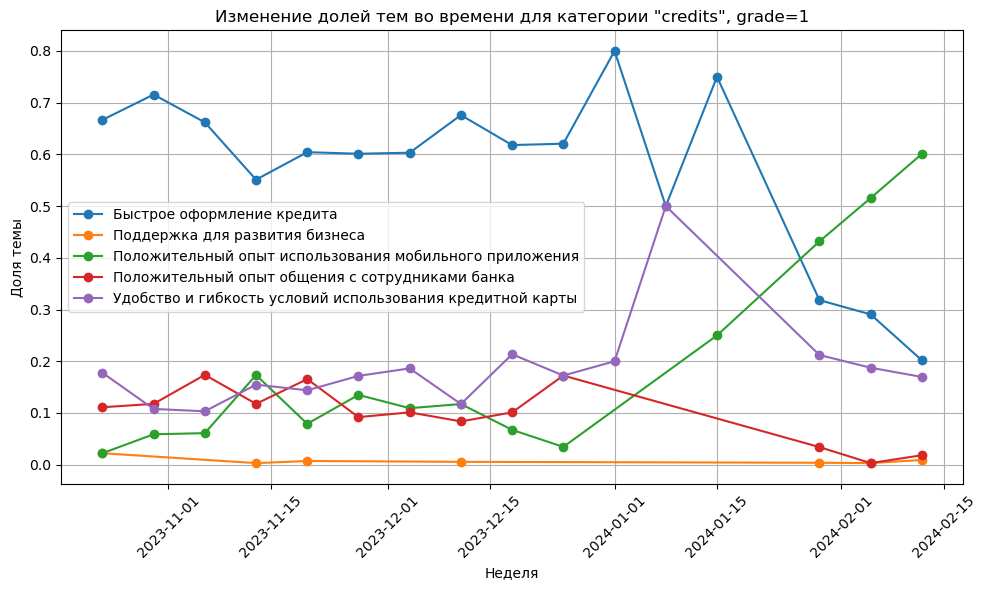

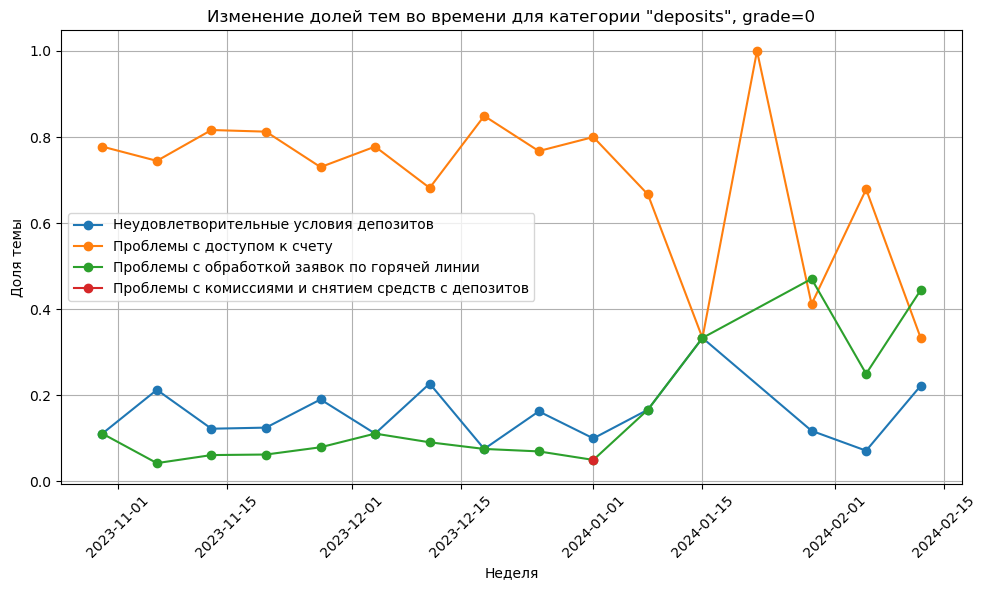

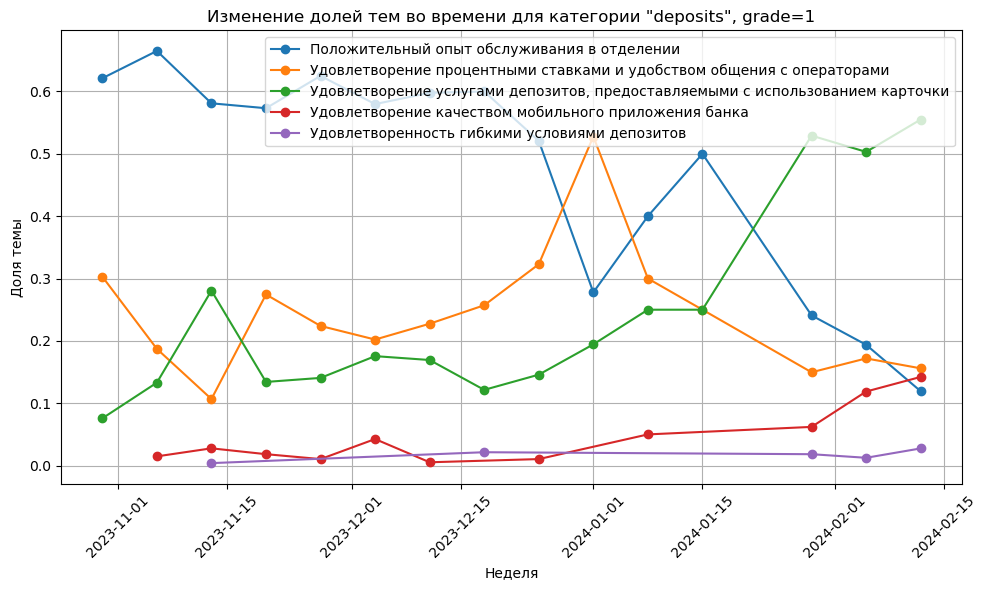

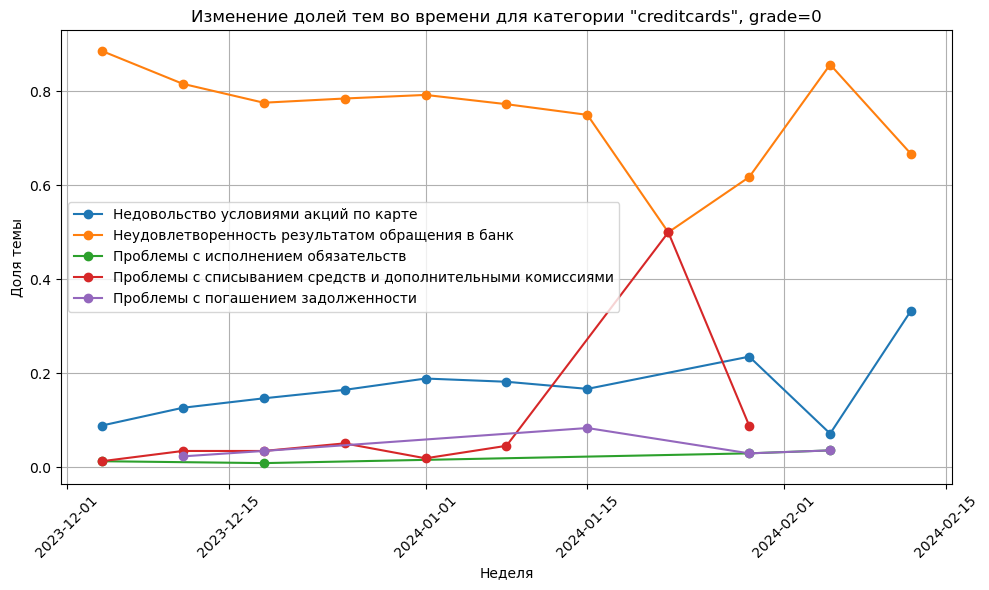

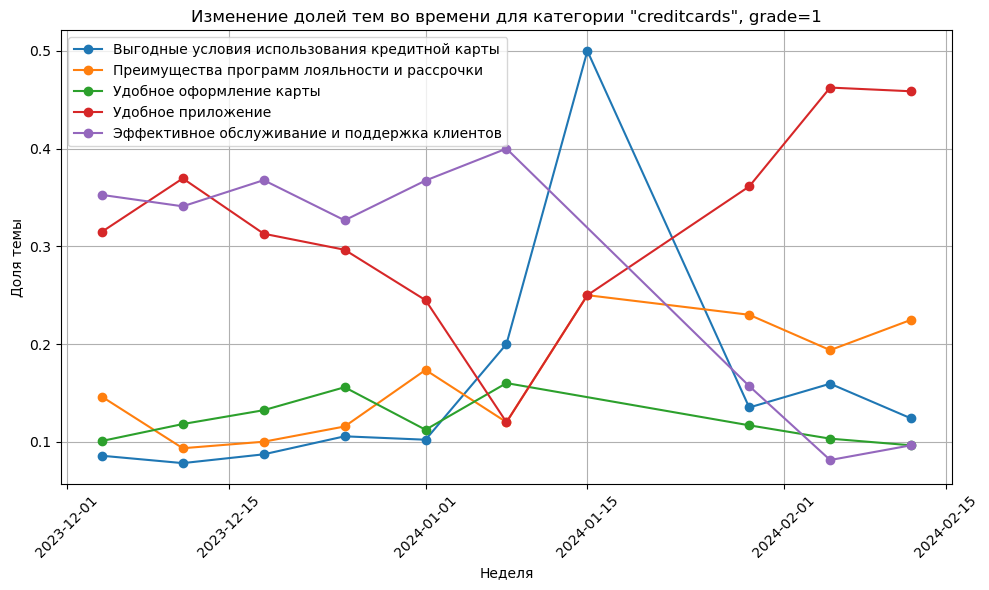

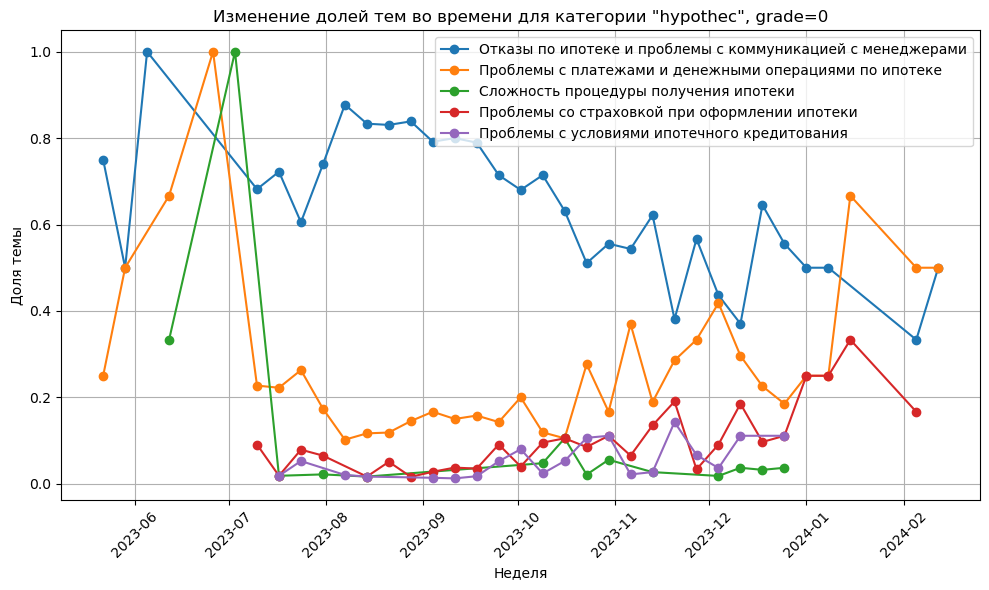

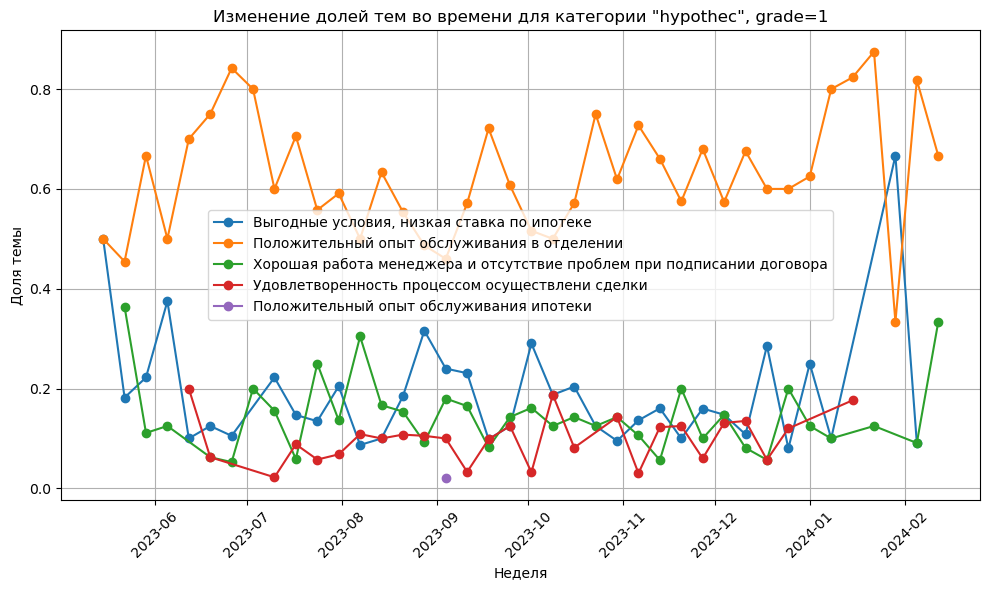

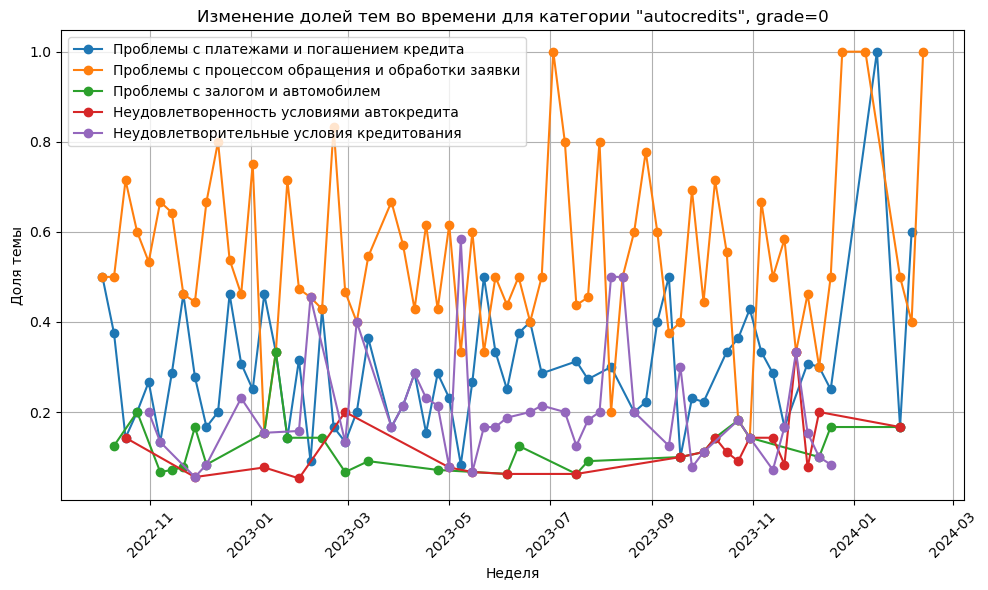

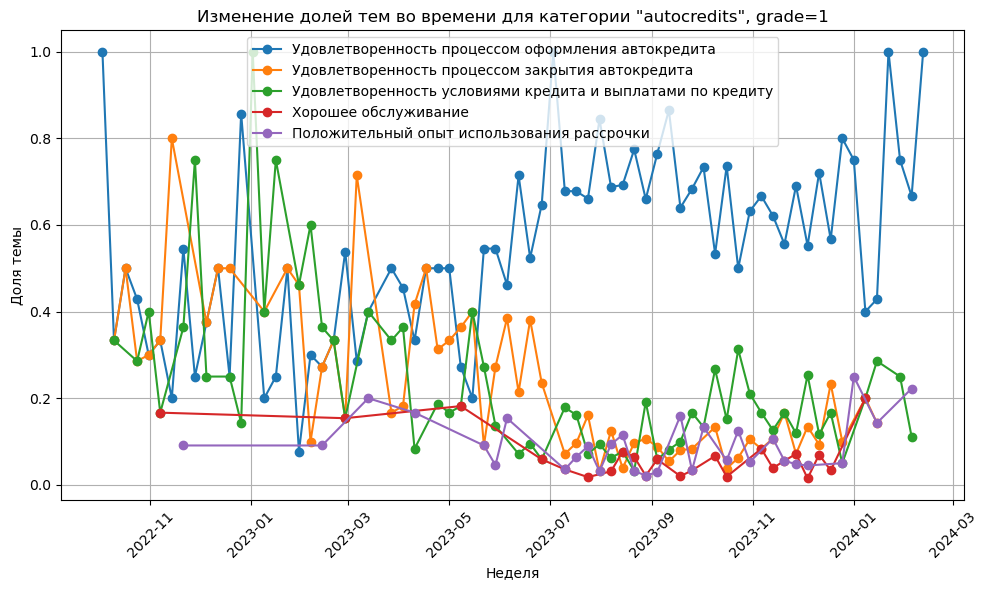

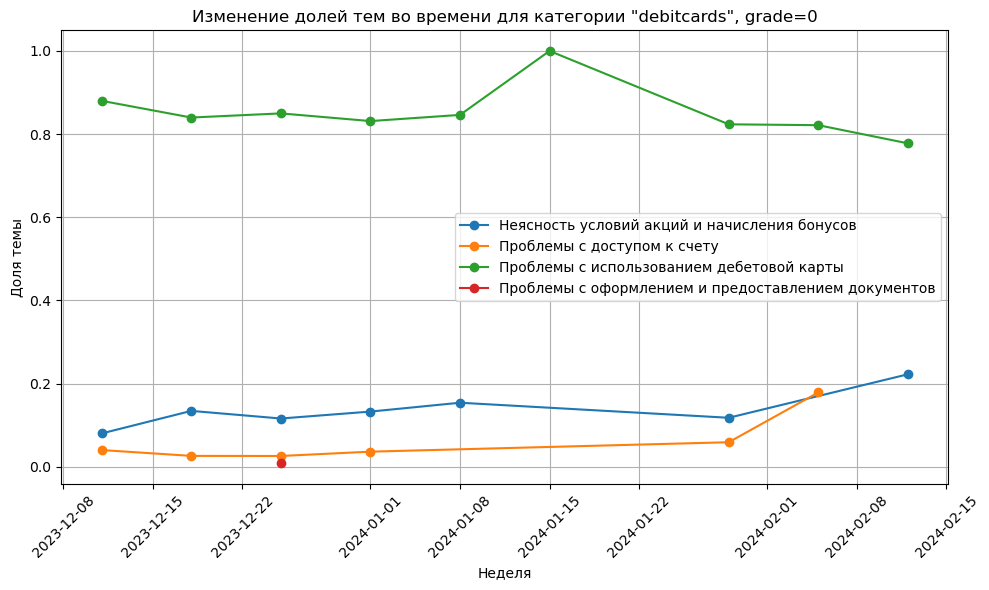

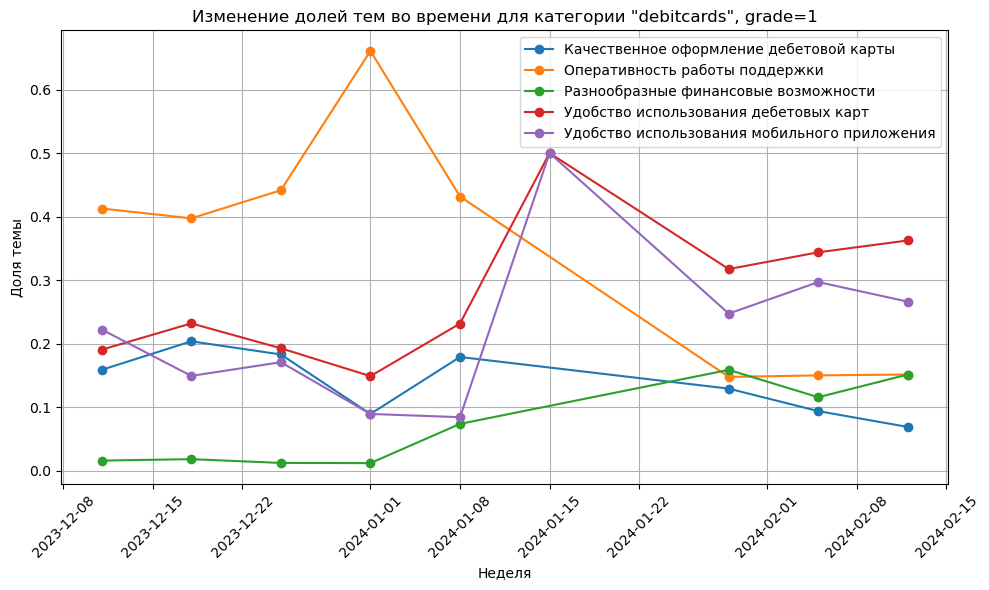

In [17]:
# посмотрим на измение долей тем во времени (по неделям) для разных категорий 

data['date'] = pd.to_datetime(data['date'])

data['week_start'] = data['date'] - pd.to_timedelta(data['date'].dt.weekday, unit='d')

topic_counts = data.groupby(['week_start', 'topics', 'category', 'grade']).size().reset_index(name='count')

topic_counts['total_reviews'] = topic_counts.groupby(['week_start', 'category', 'grade'])['count'].transform('sum')

topic_counts['share_of_topic'] = topic_counts['count'] / topic_counts['total_reviews']

categories = data['category'].unique()
grades = data['grade'].unique()

for category in categories:
    for grade in grades:
        plt.figure(figsize=(10, 6))
        plt.title(f'Изменение долей тем во времени для категории "{category}", grade={grade}')
        plt.xlabel('Неделя')
        plt.ylabel('Доля темы')
        plt.xticks(rotation=45)
        
        filtered_data = topic_counts[(topic_counts['category'] == category) & (topic_counts['grade'] == grade)]
        
        for topic in filtered_data['topics'].unique():
            topic_data = filtered_data[filtered_data['topics'] == topic]
            plt.plot(topic_data['week_start'], topic_data['share_of_topic'], marker='o', label=topic)
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

**На основе этих графиков можно отследить особенности развития разных категорий:**

1. **Кредиты**
- В начале 2024 года остро встала проблема с платежами и счетами пользователей, примерно через месяц проблему удалось сгладить
- Проблема с кредитной историей и исполнительным производством - очень редкая
- Выделенные проблемы находятся примерно на неизменяемом уровне на протяжении времени
- Главное преимущество в категории - быстрое оформление - стало постепенно угасать
- Пользователи все чаще в последнее время стали отмечать положительный опыт использования мобильного приложения

2. **Депозиты**
- Самая популярная на протяжении долгого времени проблема связана с доступом к счету
- Последние месяцы возросла популярность проблемы, связанной с обработкой заявок по горячей линии
- Последние месяцы возрос уровень удовлетворения услугами депозитов, предоставляемых с использованием карточки
- Положительный опыт обслуживани в отделениях падает

3. **Кредитные карты**
- Самая актуальная проблема на протяжении долгого времени - неудовлетворенность результатом обращения в банк
- В начале 2024 года обострилась проблема списывания средств и дополнительных комиссий 
- Возрастает удовлетворенность удобным приложением
- Эффективное обсуживание и поддержка клиентов сокращается

4. **Ипотека**
- Проблемы со сложностью получения ипотеки и платежами резко сократились летом 2023 года
- Количество жалоб на отказы по ипотекам постепенно сокращается
- Положительный опыт обслуживания в отделении - самая частая тема для положительных отзывов касательно ипотек

5. **Автоокредиты**
- В категории наблюдается сильная волатильность проблем
- Доминирующая проблема связана с процессом обращения и обработки заявки
- С середины 2023 года растет удовлетворенност процессом оормления автокредита


6. **Дебетовые карты**
- Самая глобальная и стабильная проблема связана с использования дебетовых карт
- Сокращается удовлетворенность оперативностью работы поддержки
- Растет удовлетворенность от удобства использования дебетовых карт


### В разрезе банков

In [18]:
data_top_banks = data.copy()
size_of_segment = data_top_banks.groupby(['bank', 'category', 'grade'])['topics'].size().to_frame()
size_of_segment = size_of_segment.reset_index(level = [0, 1, 2]).rename(columns = {'topics' : 'size of segment'})
grouped_data = data_top_banks.groupby(['bank', 'category', 'grade'])['topics'].apply(lambda x: x.mode().iloc[0]).reset_index()
topic_counts = data_top_banks.groupby(['bank', 'category', 'grade'])['topics'].apply(lambda x: x.value_counts(normalize=True)).to_frame()
topic_counts = topic_counts.reset_index(level = [0, 1, 2, 3]).rename(columns = {'level_3' : 'topics', 'topics' : 'share of topic among segment'})
topic_counts['share of topic among segment'] = topic_counts['share of topic among segment'].apply(lambda x: round(x, 2))
grouped_data = grouped_data.merge(topic_counts, on=['bank', 'category', 'grade', 'topics'], how='left')
grouped_data = grouped_data.merge(size_of_segment, on=['bank', 'category', 'grade'], how='left')
helpful_frame = grouped_data.groupby(['bank', 'category'])['size of segment'].sum().rename('size')
grouped_data = grouped_data.merge(helpful_frame, on=['bank', 'category'], how='left')
grouped_data['share of such sentiment among category'] = (grouped_data['size of segment'] / grouped_data['size']).apply(lambda x: round(x, 2))
grouped_data.drop(columns = ['size'], inplace = True)

Пример:

In [19]:
grouped_data[grouped_data['bank'] == 'Тинькофф Банк']

,bank,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
389,Тинькофф Банк,autocredits,0,Проблемы с процессом обращения и обработки заявки,0.78,77,0.37
390,Тинькофф Банк,autocredits,1,Удовлетворенность процессом оформления автокре...,0.81,132,0.63
391,Тинькофф Банк,creditcards,0,Неудовлетворенность результатом обращения в банк,0.90,61,0.30
392,Тинькофф Банк,creditcards,1,Эффективное обслуживание и поддержка клиентов,0.55,140,0.70
393,Тинькофф Банк,credits,0,Проблемы с обслуживанием и обработкой заявок,0.62,52,0.46
394,Тинькофф Банк,credits,1,Быстрое оформление кредита,0.35,62,0.54
395,Тинькофф Банк,debitcards,0,Проблемы с использованием дебетовой карты,0.90,72,0.27
396,Тинькофф Банк,debitcards,1,Оперативность работы поддержки,0.66,198,0.73
397,Тинькофф Банк,deposits,0,Проблемы с доступом к счету,0.50,18,0.19
398,Тинькофф Банк,deposits,1,"Удовлетворение услугами депозитов, предоставля...",0.44,77,0.81


In [28]:
def plot_topics_over_time(bank, category):
    filtered_data = data[(data['bank'] == bank) & (data['category'] == category)]

    topic_counts = filtered_data.groupby(['week_start', 'topics', 'grade']).size().reset_index(name='count')

    topic_counts['total_reviews'] = topic_counts.groupby(['week_start', 'grade'])['count'].transform('sum')

    topic_counts['share_of_topic'] = topic_counts['count'] / topic_counts['total_reviews']

    grades = filtered_data['grade'].unique()

    for grade in grades:
        plt.figure(figsize=(10, 6))
        plt.title(f'Изменение долей тем во времени для банка "{bank}", категория "{category}", grade={grade}')
        plt.xlabel('Неделя')
        plt.ylabel('Доля темы')
        plt.xticks(rotation=45)
        
        filtered_grade_data = topic_counts[topic_counts['grade'] == grade]
        
        for topic in filtered_grade_data['topics'].unique():
            topic_data = filtered_grade_data[filtered_grade_data['topics'] == topic]
            plt.plot(topic_data['week_start'], topic_data['share_of_topic'], marker='o', label=topic)
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

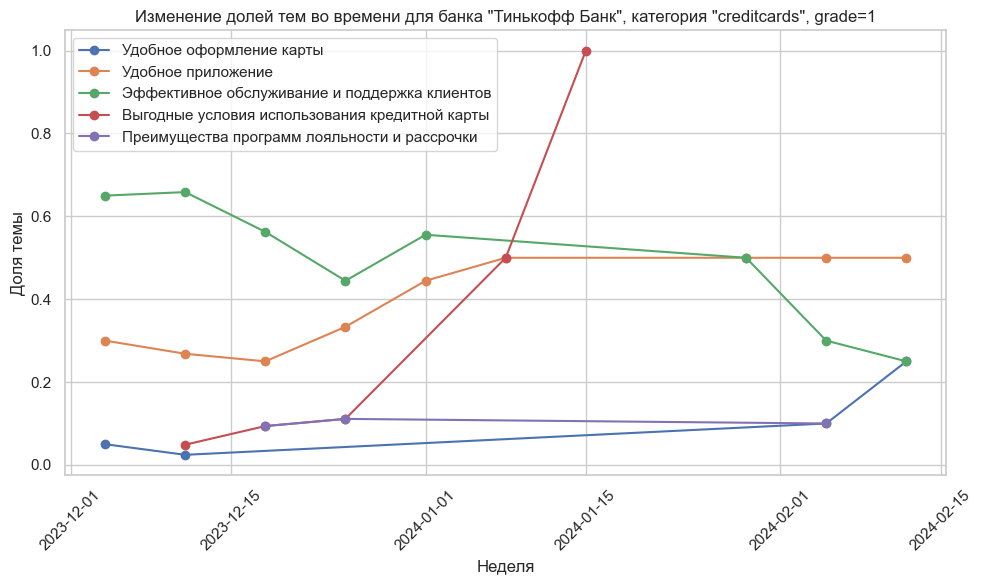

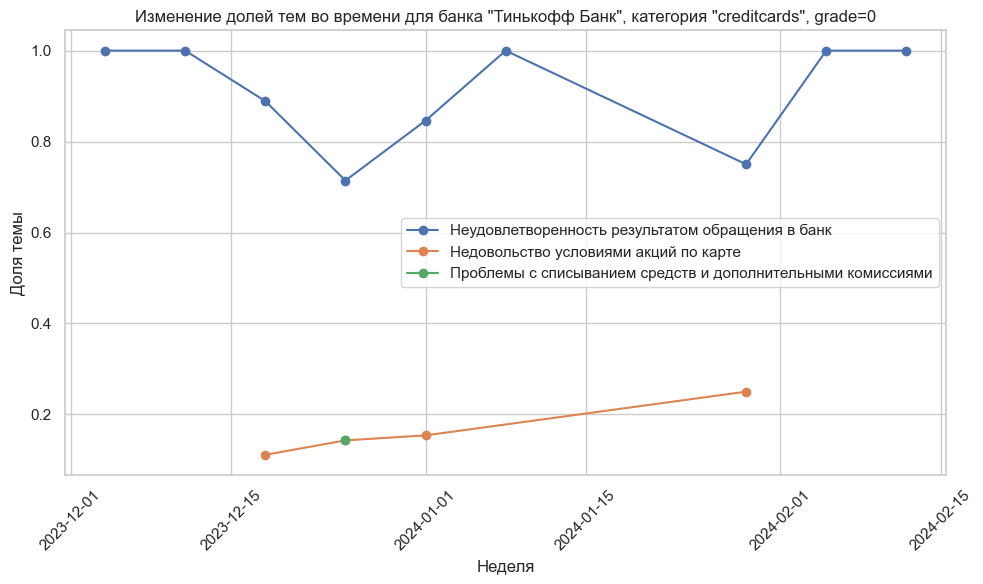

In [30]:
bank = 'Тинькофф Банк'
category = 'creditcards'
plot_topics_over_time(bank, category)

In [21]:
grouped_data[grouped_data['bank'] == 'Альфа-Банк']

,bank,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
42,Альфа-Банк,autocredits,0,Проблемы с процессом обращения и обработки заявки,1.00,18,0.07
43,Альфа-Банк,autocredits,1,Удовлетворенность процессом оформления автокре...,0.87,245,0.93
44,Альфа-Банк,creditcards,0,Неудовлетворенность результатом обращения в банк,0.83,105,0.12
45,Альфа-Банк,creditcards,1,Эффективное обслуживание и поддержка клиентов,0.42,785,0.88
46,Альфа-Банк,credits,0,Проблемы с обслуживанием и обработкой заявок,0.54,57,0.16
47,Альфа-Банк,credits,1,Быстрое оформление кредита,0.39,298,0.84
48,Альфа-Банк,debitcards,0,Проблемы с использованием дебетовой карты,0.75,118,0.15
49,Альфа-Банк,debitcards,1,Оперативность работы поддержки,0.41,679,0.85
50,Альфа-Банк,deposits,0,Проблемы с доступом к счету,0.62,34,0.08
51,Альфа-Банк,deposits,1,"Удовлетворение услугами депозитов, предоставля...",0.44,381,0.92


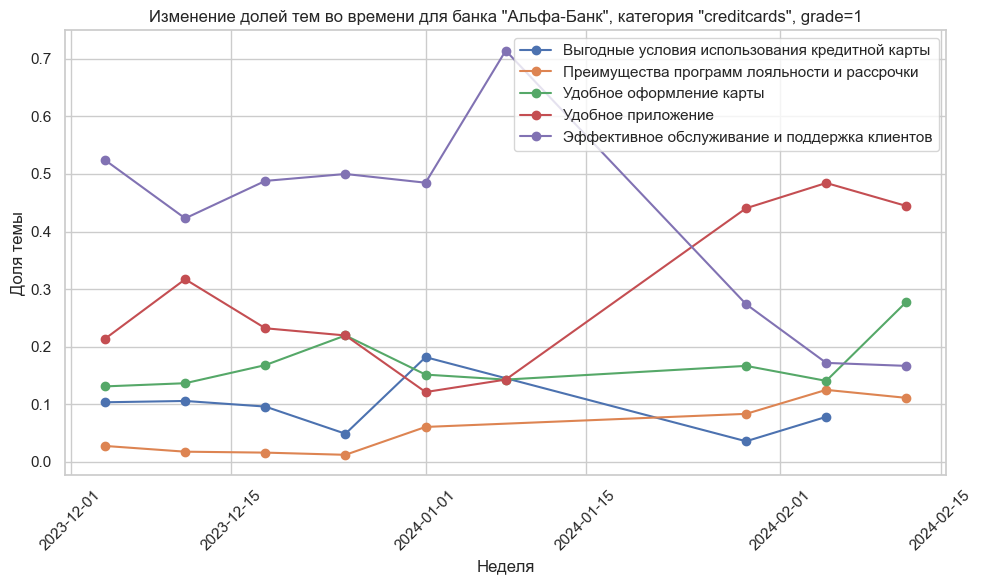

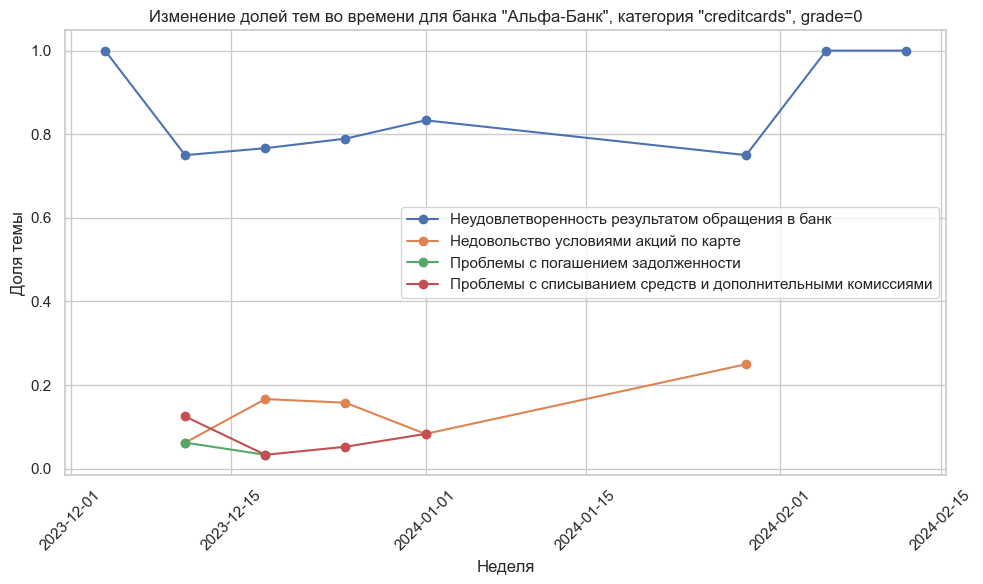

In [31]:
bank = 'Альфа-Банк'
category = 'creditcards'
plot_topics_over_time(bank, category)

Банки могут оценивать свои сильные и слабые стороны, смотря на динамику изменений отзывов во времени и сравнивая себя с конкурентами

Так, например, можно уведеть, что доля положительных отзывов об удобном приложении Альфа-Банка начало расти, когда аналогичные отзывы для Тинькофф банка остались без измененний.

Такие сравнения могут помочь банкам развиваться и отслеживать ситуацию у конкурентов

## Ключевые проблемы и достоинства работы банков в разрезе городов 

In [32]:
cities_with_more_than_200 = data.groupby('city').size()[data.groupby('city').size() > 200].index
data_top_citys = data[data['city'].isin(cities_with_more_than_200)]
size_of_segment = data_top_citys.groupby(['city', 'category', 'grade'])['topics'].size().to_frame()
size_of_segment = size_of_segment.reset_index(level = [0, 1, 2]).rename(columns = {'topics' : 'size of segment'})
grouped_data = data_top_citys.groupby(['city', 'category', 'grade'])['topics'].apply(lambda x: x.mode().iloc[0]).reset_index()
topic_counts = data_top_citys.groupby(['city', 'category', 'grade'])['topics'].apply(lambda x: x.value_counts(normalize=True)).to_frame()
topic_counts = topic_counts.reset_index(level = [0, 1, 2, 3]).rename(columns = {'level_3' : 'topics', 'topics' : 'share of topic among segment'})
topic_counts['share of topic among segment'] = topic_counts['share of topic among segment'].apply(lambda x: round(x, 2))
grouped_data = grouped_data.merge(topic_counts, on=['city', 'category', 'grade', 'topics'], how='left')
grouped_data = grouped_data.merge(size_of_segment, on=['city', 'category', 'grade'], how='left')
helpful_frame = grouped_data.groupby(['city', 'category'])['size of segment'].sum().rename('size')
grouped_data = grouped_data.merge(helpful_frame, on=['city', 'category'], how='left')
grouped_data['share of such sentiment among category'] = (grouped_data['size of segment'] / grouped_data['size']).apply(lambda x: round(x, 2))
grouped_data.drop(columns = ['size'], inplace = True)
grouped_data

,city,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
0,Воронеж,autocredits,0,Неудовлетворительные условия кредитования,0.43,7,0.28
1,Воронеж,autocredits,1,Удовлетворенность процессом оформления автокре...,0.67,18,0.72
2,Воронеж,creditcards,0,Неудовлетворенность результатом обращения в банк,0.94,16,0.30
3,Воронеж,creditcards,1,Удобное приложение,0.37,38,0.70
4,Воронеж,credits,0,Проблемы с обслуживанием и обработкой заявок,0.54,13,0.28
...,...,...,...,...,...,...,...
163,Челябинск,debitcards,1,Удобство использования дебетовых карт,0.34,29,0.76
164,Челябинск,deposits,0,Проблемы с доступом к счету,0.80,5,0.17
165,Челябинск,deposits,1,Положительный опыт обслуживания в отделении,0.50,24,0.83
166,Челябинск,hypothec,0,Отказы по ипотеке и проблемы с коммуникацией с...,0.82,11,0.29


In [35]:
grouped_data[grouped_data['city'] == 'Воронеж']

,city,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
0,Воронеж,autocredits,0,Неудовлетворительные условия кредитования,0.43,7,0.28
1,Воронеж,autocredits,1,Удовлетворенность процессом оформления автокре...,0.67,18,0.72
2,Воронеж,creditcards,0,Неудовлетворенность результатом обращения в банк,0.94,16,0.30
3,Воронеж,creditcards,1,Удобное приложение,0.37,38,0.70
4,Воронеж,credits,0,Проблемы с обслуживанием и обработкой заявок,0.54,13,0.28
5,Воронеж,credits,1,Быстрое оформление кредита,0.56,34,0.72
6,Воронеж,debitcards,0,Проблемы с использованием дебетовой карты,0.71,14,0.33
7,Воронеж,debitcards,1,Удобство использования дебетовых карт,0.46,28,0.67
8,Воронеж,deposits,0,Проблемы с доступом к счету,0.67,9,0.23
9,Воронеж,deposits,1,Удовлетворение процентными ставками и удобство...,0.42,31,0.78


In [36]:
grouped_data[grouped_data['city'] == 'Москва']

,city,category,grade,topics,share of topic among segment,size of segment,share of such sentiment among category
48,Москва,autocredits,0,Проблемы с процессом обращения и обработки заявки,0.53,165,0.32
49,Москва,autocredits,1,Удовлетворенность процессом оформления автокре...,0.72,347,0.68
50,Москва,creditcards,0,Неудовлетворенность результатом обращения в банк,0.84,127,0.20
51,Москва,creditcards,1,Удобное приложение,0.39,495,0.80
52,Москва,credits,0,Проблемы с обслуживанием и обработкой заявок,0.44,148,0.22
53,Москва,credits,1,Быстрое оформление кредита,0.43,522,0.78
54,Москва,debitcards,0,Проблемы с использованием дебетовой карты,0.86,163,0.26
55,Москва,debitcards,1,Удобство использования мобильного приложения,0.28,471,0.74
56,Москва,deposits,0,Проблемы с доступом к счету,0.82,175,0.20
57,Москва,deposits,1,Положительный опыт обслуживания в отделении,0.50,715,0.80


Использование модели для анализа отзывов позволяет **значительно расширить возможности понимания клиентского опыта и выявления ключевых тенденций:**

- Модель может автоматически классифицировать отзывы по ключевым темам, помогая быстро понять основные проблемы или положительные моменты, которые волнуют клиентов.
- Разделение отзывов на позитивные и негативные помогает быстрее реагировать на жалобы и отмечать достижения.
- Можно оценивать клиентские отзывы в разрезе различных категорий продуктов, например, кредитных карт, ипотек, депозитов и т.д., чтобы определить, какие продукты вызывают больше всего нареканий или, наоборот, положительных отзывов.
- Модель позволяет сравнивать отзывы между различными банками, выявляя сильные и слабые стороны каждого из них и помогая конкурентному анализу.
- Использование модели для анализа отзывов по временным промежуткам (неделям, месяцам) помогает отслеживать изменения в восприятии клиентов со временем и выявлять тренды.
- Можно оценивать, как изменяются отзывы после внедрения новых продуктов, услуг или улучшений.
- Модель позволяет анализировать отзывы по различным городам, что помогает выявить региональные особенности восприятия банковских услуг.
- На основе географического анализа можно разрабатывать более таргетированные стратегии для каждого региона.
